In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
import time

# 读取数据

In [2]:
def read_data_ml100k():
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('../../data/ml-100k/u.data', '\t', names=names,engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

# 分割数据集
将数据集分成训练集和测试集。
以下函数提供了两种拆分模式，包括随机和seq-aware。
在随机模式下，该函数在不考虑时间戳的情况下随机拆分 100k 次交互，默认使用 90% 的数据作为训练样本，其余 10% 作为测试样本。
在 seq-aware 模式中，忽略了用户最近为测试评分的项目，将用户的历史交互作为训练集。用户历史交互根据时间戳从最旧到最新排序。此模式将用于序列感知推荐部分。

In [3]:
def split_data_ml100k(data, num_users, split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time)) # 如果键不在字典里，setdefault将键和默认值添加到字典中，最后返回该键对应的值。这里返回list，通过append将所有相同user的item放到同一个key对应的value里。
            if u not in test_items or test_items[u][-1] < time: # 将最新的item放到test_items
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3])) # 将每个user对应的value 按照时间戳从小到大排序放到train_list
        test_data = [(key, *value) for key, value in test_items.items()] # 将test_items变成list
        train_data = [item for item in train_list if item not in test_data] #将train_list不在test_data里的元素放到train_data
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = np.random.uniform(0, 1, (len(data))) < 1 - test_ratio # 生成(len(data),)大小的bool类型数组 随机test_ratio比例的元素为False，其余为True
        neg_mask = [not x for x in mask] # 生成len(data)长度的bool类型list 元素和mask相反
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

# 定义数据集

In [4]:
class MovieLensDataset(Dataset):
    def __init__(self, users, items, scores,transform=None):
        self.users = users
        self.items = items
        self.scores = scores
        self.transform = transform

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = torch.tensor(self.users[idx],dtype=torch.int)
        item = torch.tensor(self.items[idx],dtype=torch.int)
        score = torch.tensor(self.scores[idx],dtype=torch.float)
        return user,item,score

# 加载数据
将训练集和测试集转换为列表和字典/矩阵。
以下函数逐行读取数据帧并从零开始枚举用户/项目的索引。然后该函数返回用户、项目、评级和记录交互的字典/矩阵的列表。可以将反馈类型指定为显式或隐式。

In [5]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1) #0~942 0~1681
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index) # 隐式则为字典 key为user，value为按时间排序的item list
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter


def split_and_load_ml100k(split_mode='random', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    # transform = Lambda(lambda x: torch.tensor(x,dtype=torch.float))
    train_set = MovieLensDataset(np.array(train_u), np.array(train_i), np.array(train_r))
    test_set = MovieLensDataset(np.array(test_u), np.array(test_i), np.array(test_r))
    train_iter = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_iter = DataLoader(test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [6]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k()
print(num_users,num_items)

C:\Users\12548\AppData\Local\Temp/ipykernel_14848/443709186.py:19: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only
  data, num_users, num_items = read_data_ml100k()


943 1682


# MF模型

In [7]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.P = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors)
        self.Q = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id) #(b,num_factors)
        Q_i = self.Q(item_id) #(b,num_factors)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + b_u.squeeze() + b_i.squeeze()
        return outputs.flatten()

In [9]:
def evaluate_loss(data_iter, net,loss, device=None):
    """
    输出y为某个值时
    :param data_iter:
    :param net:
    :param device:
    :return:
    """
    with torch.no_grad():
        for u,i, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            y_hat = net(u.to(device),i.to(device))
            y = y.to(device)
            l = loss(y_hat, y).cpu().item()
            net.train() # 改回训练模式
    return l
def train(net, train_iter, test_iter, optimizer,loss, device, num_epochs,oneHotEncoder=None,scheduler = None):
    net = net.to(device)
    print("training on ", device)
    plt_epoch = []
    plt_train_loss = []
    plt_test_loss = []
    for epoch in range(num_epochs):
        plt_epoch.append(epoch)
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for u,i, y in tqdm(train_iter):
            u = u.to(device)
            i = i.to(device)
            y = y.to(device)
            y_hat = net(u,i)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            # grad_clipping(net, 1)
            optimizer.step()
            train_l_sum += l.cpu().item()
            n += y.shape[0] # batch_num
            batch_count += 1
        if scheduler:
            scheduler.step()
        test_loss = evaluate_loss(test_iter, net,loss,device)
        plt_test_loss.append(test_loss)
        plt_train_loss.append(train_l_sum / batch_count)
        print('epoch %d, train_loss %.4f,train_loss %.4f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count,test_loss, time.time() - start))
    plt.plot(plt_epoch, plt_train_loss, color='r', label='train')  # r表示红色
    plt.plot(plt_epoch, plt_test_loss, color='b', label='test')  # r表示红色
    plt.show()

training on  cuda


100%|██████████| 352/352 [00:03<00:00, 109.00it/s]


epoch 1, train_loss 6.2981,train_loss 6.2290, time 3.4 sec


100%|██████████| 352/352 [00:01<00:00, 192.49it/s]


epoch 2, train_loss 5.4193,train_loss 5.4890, time 2.0 sec


100%|██████████| 352/352 [00:01<00:00, 199.26it/s]


epoch 3, train_loss 4.6346,train_loss 4.8323, time 1.9 sec


100%|██████████| 352/352 [00:02<00:00, 172.48it/s]


epoch 4, train_loss 3.9401,train_loss 4.2462, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 173.71it/s]


epoch 5, train_loss 3.3304,train_loss 3.7358, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 161.26it/s]


epoch 6, train_loss 2.8050,train_loss 3.2955, time 2.3 sec


100%|██████████| 352/352 [00:02<00:00, 163.24it/s]


epoch 7, train_loss 2.3639,train_loss 2.9269, time 2.4 sec


100%|██████████| 352/352 [00:02<00:00, 159.33it/s]


epoch 8, train_loss 2.0031,train_loss 2.6317, time 2.4 sec


100%|██████████| 352/352 [00:02<00:00, 164.86it/s]


epoch 9, train_loss 1.7163,train_loss 2.3824, time 2.3 sec


100%|██████████| 352/352 [00:02<00:00, 168.05it/s]


epoch 10, train_loss 1.4929,train_loss 2.1917, time 2.3 sec


100%|██████████| 352/352 [00:02<00:00, 175.70it/s]


epoch 11, train_loss 1.3206,train_loss 2.0471, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 175.40it/s]


epoch 12, train_loss 1.1891,train_loss 1.9276, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 169.11it/s]


epoch 13, train_loss 1.0886,train_loss 1.8420, time 2.3 sec


100%|██████████| 352/352 [00:02<00:00, 159.22it/s]


epoch 14, train_loss 1.0117,train_loss 1.7682, time 2.4 sec


100%|██████████| 352/352 [00:02<00:00, 175.24it/s]


epoch 15, train_loss 0.9526,train_loss 1.7084, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 166.09it/s]


epoch 16, train_loss 0.9064,train_loss 1.6614, time 2.3 sec


100%|██████████| 352/352 [00:02<00:00, 155.19it/s]


epoch 17, train_loss 0.8694,train_loss 1.6208, time 2.5 sec


100%|██████████| 352/352 [00:02<00:00, 169.07it/s]


epoch 18, train_loss 0.8398,train_loss 1.5944, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 174.18it/s]


epoch 19, train_loss 0.8149,train_loss 1.5707, time 2.2 sec


100%|██████████| 352/352 [00:02<00:00, 173.35it/s]


epoch 20, train_loss 0.7943,train_loss 1.5403, time 2.2 sec


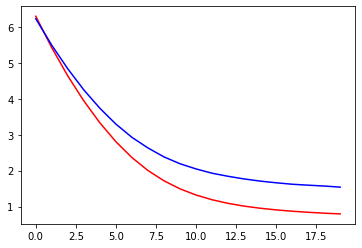

In [10]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
net = MF(30,num_users,num_items)
loss = RMSELoss
optimizer = torch.optim.Adam(net.parameters(), lr=0.002)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epoch = 20
train(net,train_iter,test_iter,optimizer,loss,device,num_epoch)